# DOFS Demo
In this notebook, we demonstrate the depth of field stretching (DOFS) algorithm we developed on simulated data. DOFS stretches the DOF of a 3D reconstruction by taking into account the effects of extended defocus within a 3D particle.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from ghostbuster.dofs import DOFS
from ghostbuster.raf import RAF

%load_ext autoreload
%autoreload 2

## Helper Functions

In [13]:
def plot_slices(arr, start_idx=0, end_idx=None, ylabel=None):
    sz = len(arr)
    if end_idx is not None:
        indices = np.linspace(start_idx, end_idx, 5).astype(int)
    else:
        indices = np.linspace(start_idx, sz - 1, 5).astype(int)
    fig, axes = plt.subplots(1, 5, constrained_layout=True, dpi=200)
    [ax.set(xticks=[], yticks=[]) for ax in axes.ravel()]
    for i, ind in enumerate(indices):
        ax = axes[i]
        ax.imshow(arr[ind])
        ax.set_title(f"slice {ind}")
    if ylabel is not None:
        axes[0].set_ylabel(ylabel)
    plt.show()

In [3]:
fft2 = lambda array: torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(array)))
ifft2 = lambda array: torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(array)))
ifftn = lambda array: torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(array)))
fftn = lambda array: torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(array)))

------
## DOFS
Here, we'll use Dataset A which contains 3500 complex-valued exitwaves of size 256x256 without noise or ice. 
These are simulated using the full multislice method for the 5MAC particle.
The open source code provided here is only implemented on a single GPU. 
To run the full dataset would require ~30Gb of GPU memory. 
As an alternative, users may set the `batchsize` to 2 or 3 to fit on a single GPU which takes up ~10Gb of GPU memory.

On our machine which uses the NVIDIA L40 GPUs, 5000 iterations of DOFS on one GPU for the full dataset takes about ~110 minutes.

Users may also set the `device` flag to `'cpu'` but the algorithm will run significantly slower.

In [4]:
groundtruth = torch.load("../datasets/5MAC_groundtruth.pt")

In [5]:
Nuse = 3500

# Dose was 20 e-/A^2 in this dataset.
# We normalize the exitwaves for proper gradient scaling
exitwaves = torch.load("../datasets/datasetA-5MAC_3500_iceless_exitwaves_256x256.pt")[
    :Nuse
]
exitwaves /= torch.sqrt(torch.tensor(20))

quaternions = torch.load("../datasets/datasetA-quaternions.pt")[:Nuse]

In [6]:
dx = 1  # [A]
wavelength = 0.02507847  # [A], for 200keV electron wave

In [7]:
dofs = DOFS(
    exitwaves, quaternions, wavelength, voxelsize=dx, device="cuda:2", batchsize=10
)

In [12]:
dofs.initialize(groundtruth=groundtruth)
dofs.iterate(
    niter=5000, stepsize=1, amplitude_contrast=True, positivity=True
)

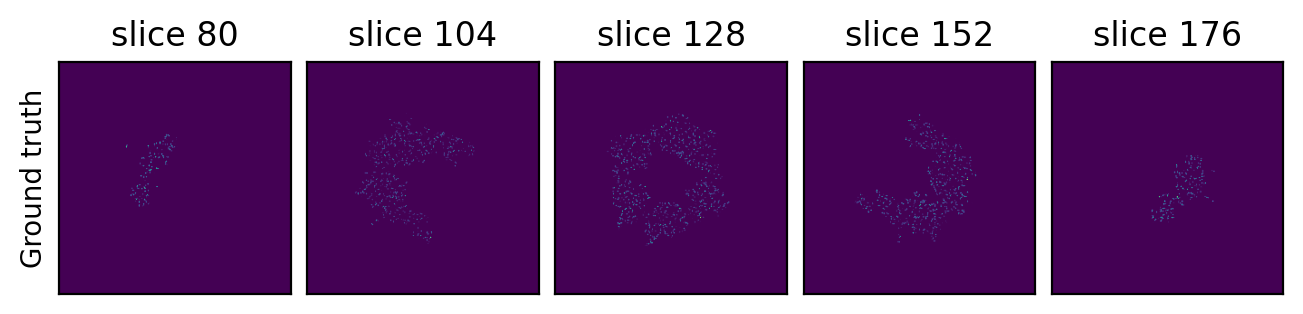

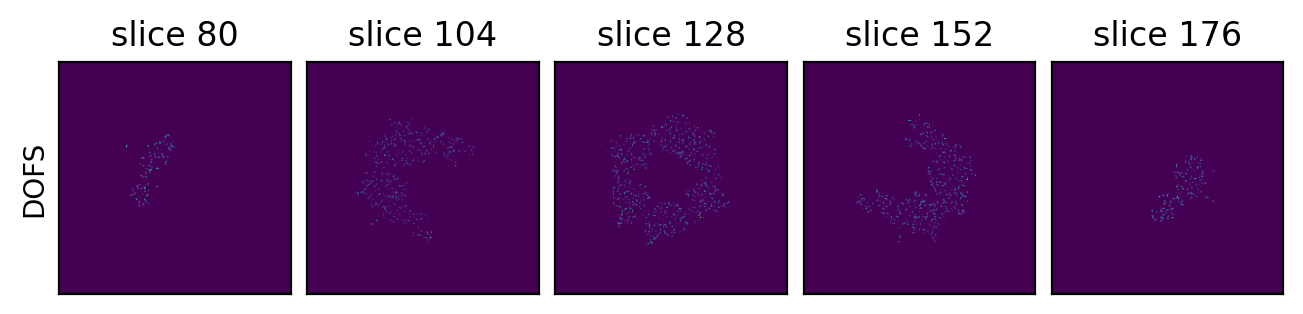

In [14]:
plot_slices(groundtruth.real, start_idx=80, end_idx=256 - 80, ylabel="Ground truth")
plot_slices(
    dofs.current.detach().cpu().real, start_idx=80, end_idx=256 - 80, ylabel="DOFS"
)

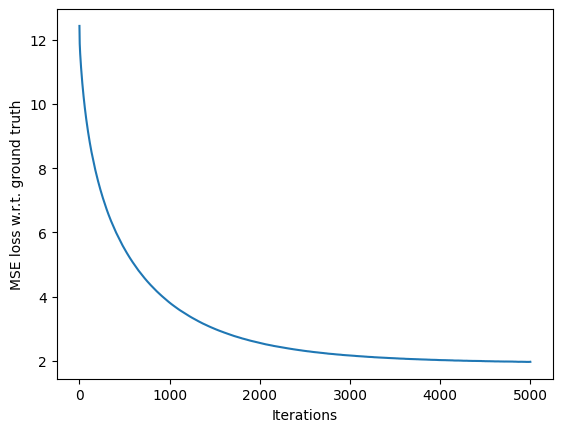

In [11]:
# plot error
plt.plot(torch.tensor(dofs.mses).to("cpu"))
plt.xlabel("Iterations")
plt.ylabel("MSE loss w.r.t. ground truth")
plt.show()